<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2024TeamC/blob/main/Code/DWH_Visualisierung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kursarbeit Datenmanagement und -Archivierung WS 23/24**

Master-Code Name-CALICO:MA


**Explorative Datenanalyse**

> Laden Libraries

In [1]:
import pandas as pd
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sklearn

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive



> Verbindung zur Datenbank



In [3]:
#connect to DB
conn = sqlite3.connect('/content/drive/MyDrive/Datenmanagement_und_Archivierung_im_Umfeld_der_Forschung/CALICO_MA/datawarehouse_new.db')
cur = conn.cursor()

print("Datenbank wurde erfolgreich geöffnet")

Datenbank wurde erfolgreich geöffnet


In [4]:
print(pd.read_sql_query('''
SELECT name FROM sqlite_master
WHERE type='table'
ORDER BY name;
     ''', conn))

            name
0     encounters
1    facts_table
2  immunizations
3    medications
4   observations
5       patients
6     procedures



> Laden die Daten aus der Datenbank in die DataFrames für die weitere Analyse



In [5]:
df_encounters = pd.read_sql_query("SELECT * FROM encounters", conn)
df_facts_table = pd.read_sql_query("SELECT * FROM facts_table", conn)
df_immunizations = pd.read_sql_query("SELECT * FROM immunizations", conn)
df_medications = pd.read_sql_query("SELECT * FROM medications", conn)
df_observations = pd.read_sql_query("SELECT * FROM observations", conn)
df_patients = pd.read_sql_query("SELECT * FROM patients", conn)
df_procedures = pd.read_sql_query("SELECT * FROM procedures", conn)

cancer_type
breast_cancer        1019
colorectal_cancer    1035
lung_cancer          1030
Name: Id, dtype: int64


<Axes: xlabel='cancer_type'>

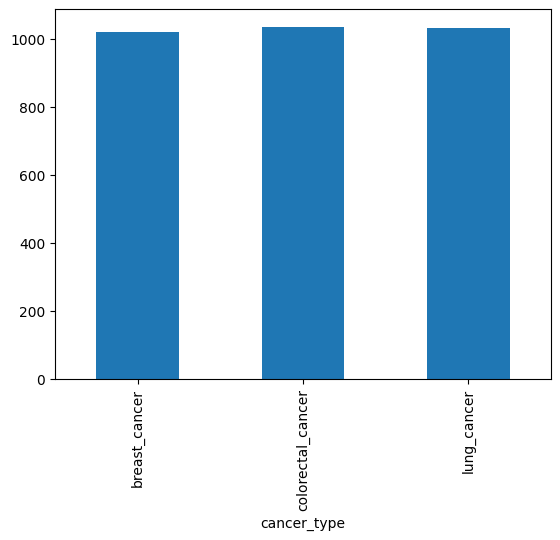

In [6]:
df2 = df_patients.groupby(['cancer_type'])['Id'].count()
print(df2)
df2.plot.bar()

In [ ]:
# Überprüfung der facts_table
#df3 = df_facts_table.head(3)
#print(df3)

Abbildungen

1.   Kosten fur jeder krebsarten (Insgesamt)
2.   Kosten fur jeder krebsarten (getrennt)
3.   Life quality (QALY) mit kosten korrelieren (Insgesamt) (death date not available)
4.   Life quality (QALY) mit kosten korrelieren (getrennt)
5.   Verhaltnis QALY - aktuelle alter (von BIRTHDATE (patients))
6.   Statistiche auswertung

##Gesamte Kosten für jede Krebsart


**Einlesen des Life costs und der Cancer costs für jede Krebsart**

In [7]:
cur.execute('''
          SELECT
        f.cancer_type,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_costs,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS cancer_costs
        FROM facts_table f
;''')

df_Costs = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'life_costs', 'cancer_costs'])


**Darstellung der gesamten Life Kostenverteilung (aggregated values, with confidence intervals)**

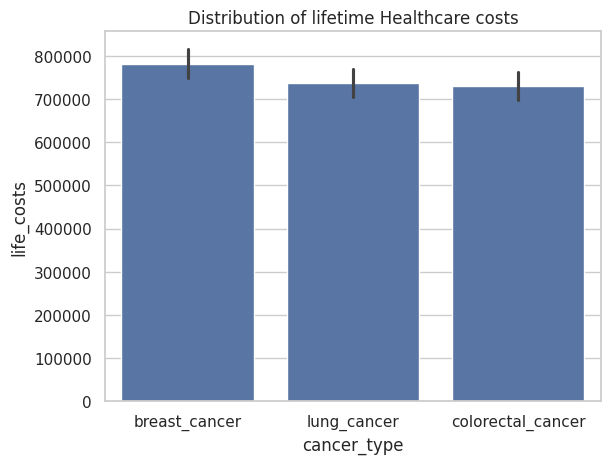

In [8]:
sns.set_theme(style="whitegrid")

g = sns.barplot(
    data=df_Costs, x="cancer_type", y="life_costs").set_title("Distribution of lifetime Healthcare costs")

**Darstellung der gesamten Cancer Kostenverteilung (aggregated values, with confidence intervals)**

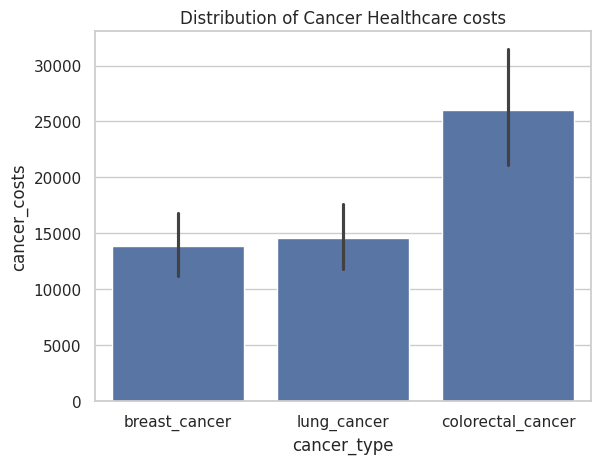

In [9]:
sns.set_theme(style="whitegrid")

g = sns.barplot(
    data=df_Costs, x="cancer_type", y="cancer_costs").set_title("Distribution of Cancer Healthcare costs")

## Kosten vs. QALY Werte

### Lung Patients

**Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Lung Cancer Patienten**

In [10]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.observations_CODE LIKE "QALY" AND f.cancer_type LIKE "lung_cancer"
        AND f.observations_AGE > 0 AND f.observations_AGE >= f.observations_VALUE
;''')

df_lung_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
#result = df_lung.head(50)
#print(result)




**Darstellung der Verteilung der vorhandenen QALY Werte bei Lungen Patienten**

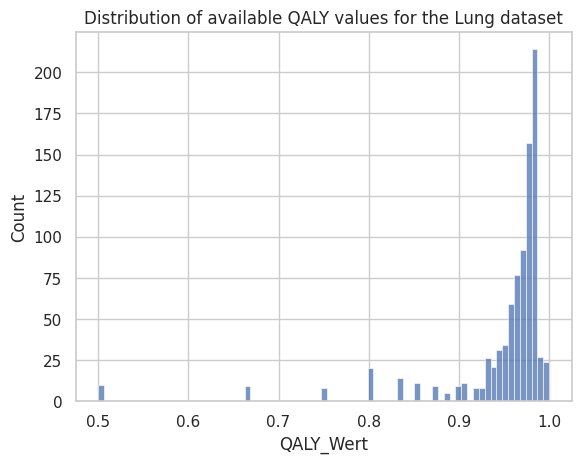

In [11]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_lung_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Lung dataset")

**Darstellung der Cancer Kosten als Funktion vom QALY für Lung Patienten**

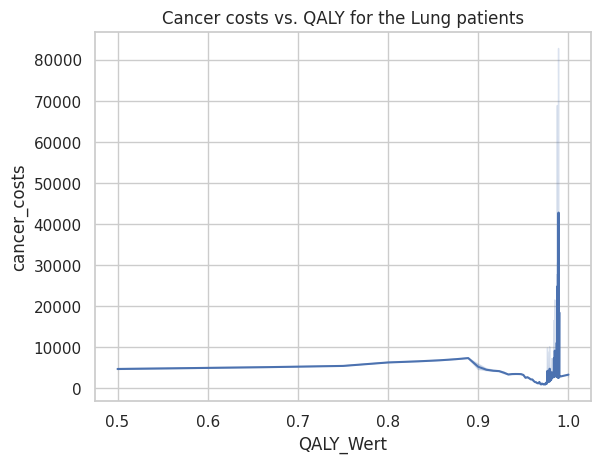

In [12]:
sns.set_theme(style="whitegrid")

g = sns.lineplot(
    data=df_lung_QALY, x="QALY_Wert",y="cancer_costs"
).set_title("Cancer costs vs. QALY for the Lung patients")


### Colorectal patients

**Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Colorectal Cancer Patienten**

In [13]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.observations_CODE LIKE "QALY" AND f.cancer_type LIKE "colorectal_cancer"
        AND f.observations_AGE > 0 AND f.observations_AGE >= f.observations_VALUE
;''')

df_colorectal_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
result = df_colorectal_QALY.head(5)
print(result)

         cancer_type  QALY  Age  Value  QALY_Wert  life_costs  cancer_costs
0  colorectal_cancer  QALY   37     36   0.972973      904391          1216
1  colorectal_cancer  QALY   39     38   0.974359      811891           947
2  colorectal_cancer  QALY   35     34   0.971429      721662          1216
3  colorectal_cancer  QALY   52     51   0.980769       18674          2034
4  colorectal_cancer  QALY   51     50   0.980392     1114095          2314


**Darstellung der Verteilung der vorhandenen QALY Werte bei Colorectal Patienten**

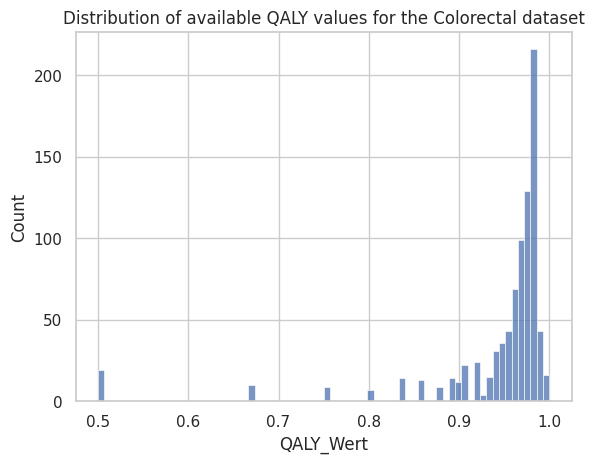

In [14]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_colorectal_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Colorectal dataset")

**Darstellung der Cancer Kosten als Funktion vom QALY für Colorectal Patienten**

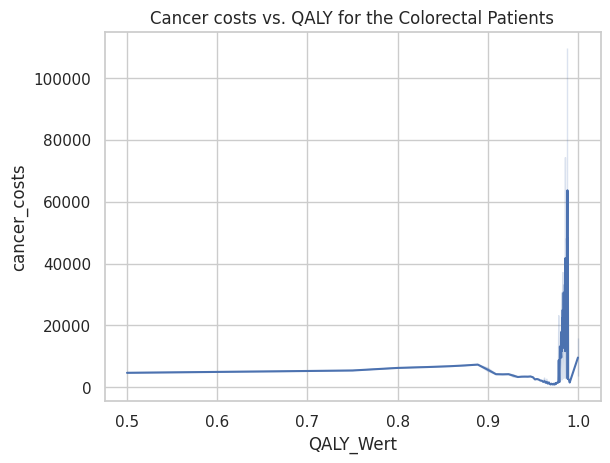

In [15]:
sns.set_theme(style="whitegrid")

g = sns.lineplot(
    data=df_colorectal_QALY, x="QALY_Wert",y="cancer_costs"
).set_title("Cancer costs vs. QALY for the Colorectal Patients")

### Breast patients

**Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Breast Cancer Patienten**

In [16]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.observations_CODE LIKE "QALY" AND f.cancer_type LIKE "breast_cancer"
        AND f.observations_AGE > 0 AND f.observations_AGE >= f.observations_VALUE
;''')

df_breast_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
result = df_breast_QALY.head(5)
print(result)

     cancer_type  QALY  Age  Value  QALY_Wert  life_costs  cancer_costs
0  breast_cancer  QALY   64     63   0.984375     1479474          7060
1  breast_cancer  QALY   56     55   0.982143     1493141          2572
2  breast_cancer  QALY   22     21   0.954545       59245          2852
3  breast_cancer  QALY   16     15   0.937500      411229          3530
4  breast_cancer  QALY   14     13   0.928571      323370          3950


**Darstellung der Verteilung der vorhandenen QALY Werte bei Breast Patienten**

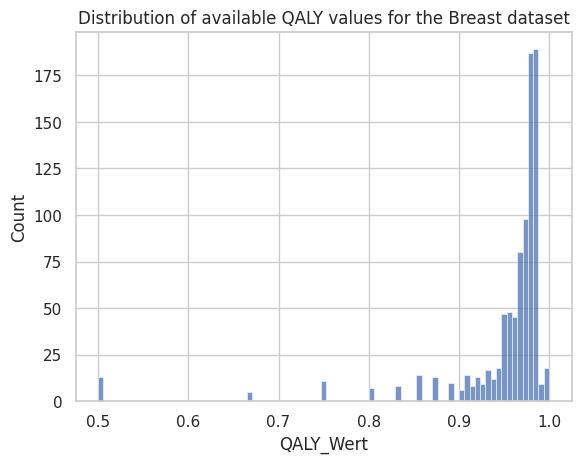

In [17]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_breast_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Breast dataset")

**Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Breast Cancer Patienten**

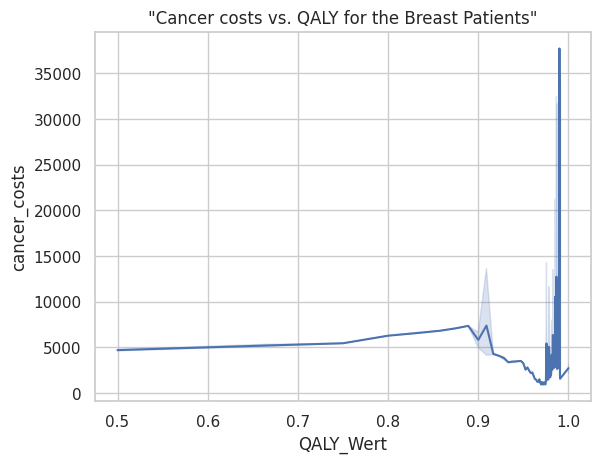

In [18]:
sns.set_theme(style="whitegrid")

g = sns.lineplot(
    data=df_breast_QALY, x="QALY_Wert",y="cancer_costs"
).set_title('"Cancer costs vs. QALY for the Breast Patients"')